In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import math

# set traditional Chinese display
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

In [22]:
# Load datasets
data = pd.read_csv('../dataset/doubles 2/doubles/convert_shot.csv', encoding='utf-8')
rally_data = pd.read_csv('../dataset/doubles 2/doubles/rally.csv', encoding='utf-8')
set_data = pd.read_csv('../dataset/doubles 2/doubles/set.csv', encoding='utf-8')
match_data = pd.read_csv('../dataset/doubles 2/doubles/match.csv', encoding='utf-8')

# Merge rally_data with set_data to include match_id
rally_set_merged = rally_data.merge(set_data[['set_id', 'match_id']], on='set_id', how='left')

# Merge rally_set_merged with match_data to include player info
rally_set_match_merged = rally_set_merged.merge(match_data[['match_id', 'win_A', 'win_B', 'lose_C', 'lose_D']], on='match_id', how='left')

# Merge with the main convert_shot data
data_merged = data.merge(rally_set_match_merged[['rally_id', 'win_A', 'win_B', 'lose_C', 'lose_D']], on='rally_id', how='left')

# Initialize columns for hit_player and partner positions
data_merged['hit_player_x'] = None
data_merged['hit_player_y'] = None
data_merged['partner_x'] = None
data_merged['partner_y'] = None

# Function to assign hit_player and partner coordinates based on player info
def assign_player_positions(row):
    if row['player'] == row['win_A']:
        row['hit_player_x'] = row['player_A_x']
        row['hit_player_y'] = row['player_A_y']
        row['partner_x'] = row['player_B_x']
        row['partner_y'] = row['player_B_y']
    elif row['player'] == row['win_B']:
        row['hit_player_x'] = row['player_B_x']
        row['hit_player_y'] = row['player_B_y']
        row['partner_x'] = row['player_A_x']
        row['partner_y'] = row['player_A_y']
    elif row['player'] == row['lose_C']:
        row['hit_player_x'] = row['player_C_x']
        row['hit_player_y'] = row['player_C_y']
        row['partner_x'] = row['player_D_x']
        row['partner_y'] = row['player_D_y']
    elif row['player'] == row['lose_D']:
        row['hit_player_x'] = row['player_D_x']
        row['hit_player_y'] = row['player_D_y']
        row['partner_x'] = row['player_C_x']
        row['partner_y'] = row['player_C_y']
    if row['hit_player_y'] < 67:
        row['hit_player_y'] = 134 - row['hit_player_y']
        row['hit_player_x'] = 61 - row['hit_player_x']
        row['partner_x'] = 61 - row['partner_x']
        row['partner_y'] = 134 - row['partner_y']
    return row

# Apply the function to each row
data_merged = data_merged.apply(assign_player_positions, axis=1)
data_merged.drop(['start_frame_num','end_frame_num','time','return_height'], axis=1, inplace=True)
# Save the updated data
data_merged.to_csv('../output/Week13/updated_convert_shot.csv', index=False, encoding='utf-8')

# Check the result
print(data_merged.head())


   shot_id  rally_id  shot_num  player ball_type  backhand  player_A_x  \
0        1         1         1       5       發短球         1   28.639847   
1        2         1         2       7       推撲球         1   34.001378   
2        3         1         3       6        挑球         1   36.690095   
3        4         1         4       8        殺球         0   24.759652   
4        5         1         5       6        平球         1   24.160234   

   player_A_y  player_B_x  player_B_y  ...  hit_height  flaw  win_A  win_B  \
0   94.300792   31.751217  113.677100  ...           2     0      5      6   
1   88.407620   32.780770  114.213560  ...           2     0      5      6   
2   87.092290   36.825915  111.609023  ...           2     0      5      6   
3  109.455966   48.761037  122.480082  ...           1     0      5      6   
4  111.525887   46.772711  118.061801  ...           2     0      5      6   

   lose_C  lose_D  hit_player_x  hit_player_y  partner_x   partner_y  
0       7      

In [23]:
def assign_player_positions(row, prev_hit_player, current_hit_player):
    hit = prev_hit_player[0]
    partner = prev_hit_player[1]
    c_hit = current_hit_player[0]
    c_partner = current_hit_player[1]
    return row[f'player_{c_hit}_x'], row[f'player_{c_hit}_y'], row[f'player_{c_partner}_x'], row[f'player_{c_partner}_y'], row[f'player_{hit}_x'], row[f'player_{hit}_y'], row[f'player_{partner}_x'], row[f'player_{partner}_y']
def player(row):
    if row['player'] == row['win_A']:
        return ["A", "B"]
    elif row['player'] == row['win_B']:
        return ["B", "A"]
    elif row['player'] == row['lose_C']:
        return ["C", "D"]
    elif row['player'] == row['lose_D']:
        return ["D", "C"]
    else:
        return None

In [24]:
# Load the datasets
# convert_shot.csv: The result after running transform.py
data = pd.read_csv('../output/Week13/updated_convert_shot.csv', encoding='utf-8')
rally_data = pd.read_csv('../dataset/doubles 2/doubles/rally.csv', encoding='utf-8')
set_data = pd.read_csv('../dataset/doubles 2/doubles/set.csv', encoding='utf-8')

# Filter players
players_filtered = data

# Get the maximum shot number for each rally
max_shots_per_rally = players_filtered.groupby('rally_id')['shot_num'].max().reset_index()
max_shots_per_rally.columns = ['rally_id', 'max_shot_num']

# Merge the max_shots_per_rally back to the players_filtered
players_filtered = players_filtered.merge(max_shots_per_rally, on='rally_id', how='left')

# Merge rally_data with set_data to include set_win information
rally_set_merged = rally_data.merge(set_data[['set_id', 'set_win']], on='set_id', how='left')

# Initialize the list to collect rows
shot_list = []


# Initialize previous shot and position variables
prev_hit_player = None

# Iterate over the filtered DataFrame rows
for idx, row in players_filtered.iterrows():
    if row['shot_num'] == 1 or row['max_shot_num'] <= 4:
        # Update previous shot position for the first valid shot
        prev_hit_player = player(row)
        continue
    
    # Check ball type and adjust as necessary
    if row['ball_type'] in ['擋小球', '勾球', '放小球', '小平球']:
        row['ball_type'] = '網前小球'
    elif row['ball_type'] == '防守回挑':
        row['ball_type'] = '挑球'
    elif row['ball_type'] in ['防守回抽', '後場抽平球']:
        row['ball_type'] = '平球'
    elif row['ball_type'] == '過度切球':
        row['ball_type'] = '切球'
    elif row['ball_type'] in ['推球', '撲球']:
        row['ball_type'] = '推撲球'
        
    hit_player_x, hit_player_y, partner_x, partner_y, oppo_hit_x, oppo_hit_y, oppo_partner_x, oppo_partner_y = assign_player_positions(row, prev_hit_player, player(row))
    
    # Prepare the new row
    newrow_hit = {
        "shot_id": row["shot_id"],
        "hit_player_x": hit_player_x,
        "hit_player_y": hit_player_y,
        "partner_x": partner_x,
        "partner_y": partner_y,
        "ball_type": row["ball_type"],
        "score": 0, 
        "score_by_error": 0
    }
    newrow_opponent = {
        "shot_id": row["shot_id"],
        "hit_player_x": oppo_hit_x,
        "hit_player_y": oppo_hit_y,
        "partner_x": oppo_partner_x,
        "partner_y": oppo_partner_y,
        "ball_type": "未擊球",
        "score": 0,
        "score_by_error": 0
    }

    # Adjust for upper court if necessary
    if newrow_hit["hit_player_y"] > 67:
        newrow_hit["hit_player_x"] = 61 - newrow_hit["hit_player_x"]
        newrow_hit["hit_player_y"] = 134 - newrow_hit["hit_player_y"]
        newrow_hit["partner_x"] = 61 - newrow_hit["partner_x"]
        newrow_hit["partner_y"] = 134 - newrow_hit["partner_y"]
        
    if newrow_opponent["hit_player_y"] > 67:
        newrow_opponent["hit_player_x"] = 61 - newrow_opponent["hit_player_x"]
        newrow_opponent["hit_player_y"] = 134 - newrow_opponent["hit_player_y"]
        newrow_opponent["partner_x"] = 61 - newrow_opponent["partner_x"]
        newrow_opponent["partner_y"] = 134 - newrow_opponent["partner_y"]

    # Check if the current shot is one of the last two shots in the rally
    if row['shot_num'] >= row['max_shot_num'] - 2:
        rally_info = rally_set_merged[rally_set_merged['rally_id'] == row['rally_id']].iloc[0]
        set_win = rally_info['set_win']
        score_team = rally_info['score_team']
        if score_team == "NULL":
            continue
            
        if "對手" in str(rally_info['score_reason']):
            newrow_hit["score_by_error"] = 1
            newrow_opponent["score_by_error"] = 1

        # Determine which team won the point
        if (row['shot_num'] == row['max_shot_num']) or (row['shot_num'] == row['max_shot_num'] - 2):
            if ("對手" not in str(rally_info['score_reason'])):
                newrow_hit["score"] = 1
                newrow_opponent["score"] = -1
            else:
                newrow_hit["score"] = -1
                newrow_opponent["score"] = 1
            shot_list.append(newrow_hit)
            shot_list.append(newrow_opponent)
        else:
            if ("對手" not in str(rally_info['score_reason'])):
                newrow_hit["score"] = -1
                newrow_opponent["score"] = 1
            else:
                newrow_hit["score"] = 1
                newrow_opponent["score"] = -1
            shot_list.append(newrow_hit)
            shot_list.append(newrow_opponent)
        

    # Update previous shot and position after each shot for the next iteration
    prev_hit_player = player(row)

# Create DataFrames for win and lose shots
total_df = pd.DataFrame(shot_list)

print("size of total_df: ", total_df.shape[0])

# Save to CSV
total_df.to_csv('../output/Week13/hit.csv', index=False, encoding='utf-8')


size of total_df:  10032


In [32]:
data = pd.read_csv('../output/Week12/hit.csv')
X = []
y = []
for idx in range(0, data.shape[0], 6):
    if data.loc[idx, 'score_by_error'] == 0:
        tmp = math.sqrt((data.loc[idx+2, 'hit_player_x'] - data.loc[idx+5, 'hit_player_x'])**2 + (data.loc[idx+2, 'hit_player_y'] - data.loc[idx+5, 'hit_player_y'])**2)
    else:
        tmp = math.sqrt((data.loc[idx+3, 'hit_player_x'] - data.loc[idx+4, 'hit_player_x'])**2 + (data.loc[idx+3, 'hit_player_y'] - data.loc[idx+4, 'hit_player_y'])**2)
    X.append(tmp)
    y.append(data.loc[idx, 'score_by_error'])
print(len(X), len(y))

385 385


In [34]:
# # Example data: numerical attribute (X) and boolean value (y)
# # X represents some numerical attribute, y represents the boolean outcome (True = 1, False = 0)
# X = np.array([[1.5], [2.3], [3.7], [4.5], [5.1], [6.2], [7.0], [8.5], [9.1], [10.0]])
# y = np.array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1])

X = np.array(X).reshape(-1, 1)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize logistic regression model
log_reg = LogisticRegression()

# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Predict the outcomes for the test data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nAccuracy: {:.2f}%".format(accuracy * 100))


Confusion Matrix:
 [[16 15]
 [14 71]]

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.52      0.52        31
           1       0.83      0.84      0.83        85

    accuracy                           0.75       116
   macro avg       0.68      0.68      0.68       116
weighted avg       0.75      0.75      0.75       116


Accuracy: 75.00%


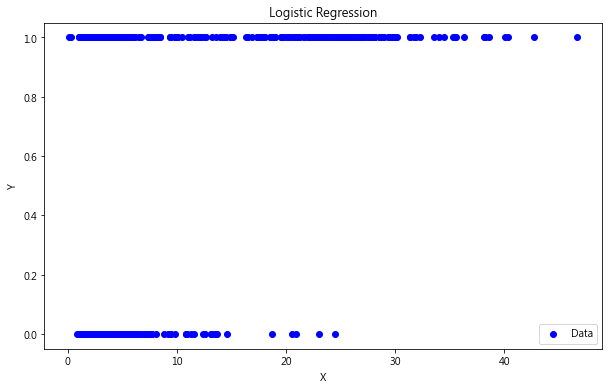

In [35]:
# Plot the data and the decision boundary
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Logistic Regression')
plt.legend()
plt.show()
